In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import viz


from tqdm import tqdm
from os import path

colors = viz.color_palette()
cnames_lin = 'green,blue,yellow,purple,red'.split(',')
lin_colors = [colors[c] for c in cnames_lin]

plt.style.use('style.mpl')

# Calculates contingency tables and plots them

Various modes of plotting, e.g. heatmap and bar plot. 

TODO: look for matches in the culture collections. We already know of one. 
https://gcm.wdcm.org/search

In [5]:
summary_df = pd.read_csv('../output/annotree/chemoauto_summary_annotree.csv')
species_results_df = pd.read_csv('../output/annotree/annotree_files/bac120_taxonomy_r95.csv')
genome_metadata = pd.read_csv('../output/annotree/annotree_files/bac120_metadata_r95.csv', low_memory=False)


species_results_df['genome_id'] = species_results_df['gtdbId'].str[3:]
species_results_df['gtdb_order'] = species_results_df['gtdb_order'].str[3:]
genome_metadata['genome_id'] = genome_metadata['accession'].str[3:]


merged = pd.merge(summary_df, genome_metadata, on='genome_id')
summary_annot_df = pd.merge(merged, species_results_df, on='genome_id')
summary_annot_df.genome_id.unique().size

summary_annot_df.to_csv('../output/annotree/chemoauto_summary_annot.csv', index=False)


In [6]:
genome_hits = summary_annot_df[['genome_id','CBB_csome_fdh', 'CBB_csome_h2ase', 'CBB_csome_fdh_h2ase','CBB_csome','gtdb_domain', 'gtdb_phylum', 'gtdb_class', 'gtdb_order', 'gtdb_genus', 'gtdb_species','gc_percentage','genome_size','checkm_completeness']]
#genome_hits = summary_annot_df[['genome_id','rubisco_csome','rubisco_csome_fdh', 'rubisco_csome_h2ase', 'rubisco_csome_fdh_h2ase','gtdb_domain', 'gtdb_phylum', 'gtdb_class', 'gtdb_order', 'gtdb_genus', 'gtdb_species']]

genome_hits = genome_hits [~(genome_hits[['CBB_csome_fdh', 'CBB_csome_h2ase', 'CBB_csome_fdh_h2ase']] == False).all(axis=1)]
genome_hits = genome_hits.sort_values(by=['CBB_csome_fdh_h2ase', 'CBB_csome_fdh'], ascending=[False, False])

len(genome_hits)

321

In [7]:
order_counts = genome_hits.groupby('gtdb_order').size().sort_values(ascending=False)
my_orders = order_counts.head(10).index
for_plotting = genome_hits[genome_hits.gtdb_order.isin(my_orders)]
for_plotting.head()

print(my_orders)

Index(['PCC-6307', 'Burkholderiales', 'Ectothiorhodospirales', 'Chromatiales',
       'Acidithiobacillales', 'Thiotrichales', 'Rhizobiales',
       'Thiohalobacterales', 'Ga0077554', 'Mycobacteriales'],
      dtype='object', name='gtdb_order')


In [8]:
cols = ['CBB_csome', 'CBB_csome_fdh', 'CBB_csome_h2ase', 'CBB_csome_fdh_h2ase']
ct = pd.crosstab(for_plotting['gtdb_order'], [for_plotting[c] for c in cols],
                 rownames=['gtdb_order'],
                 colnames=cols)
ct_vals = ct.values[:,1:]
sums = ct_vals.sum(axis=1)

false_col = tuple([False] * len(cols))
if false_col in ct.columns:
    ct = ct.drop(columns=[false_col])
    
#reorder by sums, neglecting rubisco_csome alone
order = np.argsort(sums)[::-1]
ct = ct.iloc[order]
ct = ct[(ct != 0).any(axis=1)]
ct = ct.loc[ct.sum(axis=1).sort_values(ascending=False).index]

ct



CBB_csome              True            
CBB_csome_fdh         False True       
CBB_csome_h2ase       True  False True 
CBB_csome_fdh_h2ase   False False True 
gtdb_order                             
PCC-6307                188     0    17
Burkholderiales          12     9    18
Ectothiorhodospirales     5     2    15
Chromatiales              2     0    15
Acidithiobacillales       1     1     7
Rhizobiales               0     1     3
Thiotrichales             1     1     2
Ga0077554                 1     1     1
Thiohalobacterales        3     0     0
Mycobacteriales           0     1     1

['PCC-6307' 'Burkholderiales' 'Ectothiorhodospirales' 'Chromatiales'
 'Acidithiobacillales' 'Rhizobiales' 'Thiotrichales' 'Ga0077554'
 'Thiohalobacterales' 'Mycobacteriales']


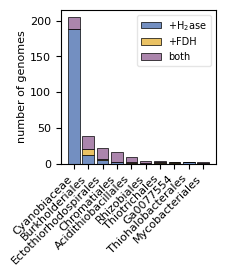

In [9]:
plt.figure(figsize=(2, 2))

# stacked bar values are along the rows below
bar_vals = ct.values

# plot the stacked bar chart
xs = np.arange(len(ct.index))
plt.bar(xs, bar_vals[:, 0], color=lin_colors[1], edgecolor='k', lw=0.5)
plt.bar(xs, bar_vals[:, 1], bottom=bar_vals[:, 0], color=lin_colors[2], edgecolor='k', lw=0.5)
plt.bar(xs, bar_vals[:, 2], bottom=bar_vals[:, 0]+bar_vals[:, 1], color=lin_colors[3], edgecolor='k', lw=0.5)

# relabel legend
plt.legend(['+H$_2$ase', '+FDH', 'both'], loc=1, framealpha=0.5)

my_xticks = ct.index.values
print(my_xticks)
# find PCC-6307, replace with its only family Cyanobiaceae
my_xticks[my_xticks == 'PCC-6307'] = 'Cyanobiaceae'

tick_pos = np.arange(0, len(my_xticks), 1)
plt.xticks(tick_pos, my_xticks, rotation=45, ha='right')
plt.ylabel('number of genomes')
#plt.ylim(0, 50)
plt.xlabel('')
plt.savefig('../output/plots/top_hits_by_order_small.pdf', bbox_inches='tight')
plt.savefig('../output/plots/top_hits_by_order_small.png', bbox_inches='tight')

plt.show()



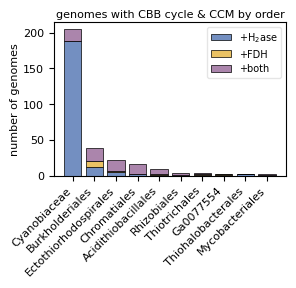

In [181]:
plt.figure(figsize=(3, 2))

# stacked bar values are along the rows below
bar_vals = ct.values

# plot the stacked bar chart
xs = np.arange(len(ct.index))
bottom = np.zeros(len(ct.index))
for i in range(bar_vals.shape[1]):
    plt.bar(xs, bar_vals[:, i], bottom=bottom, color=lin_colors[i+1],
            edgecolor='k', lw=0.5)
    bottom += bar_vals[:, i]

#plt.bar(xs, bar_vals[:, 0], color=lin_colors[0], edgecolor='k', lw=0.5)
#plt.bar(xs, bar_vals[:, 1], color=lin_colors[1], edgecolor='k', lw=0.5)
#plt.bar(xs, bar_vals[:, 2], bottom=bar_vals[:, 0], color=lin_colors[2], edgecolor='k', lw=0.5)
#plt.bar(xs, bar_vals[:, 3], bottom=bar_vals[:, 0]+bar_vals[:, 1], color=lin_colors[3], edgecolor='k', lw=0.5)

# relabel legend
plt.legend(['+H$_2$ase', '+FDH', '+both'], loc=1, framealpha=0.5)

my_xticks = ct.index.values
# find PCC-6307, replace with its only family Cyanobiaceae
my_xticks[my_xticks == 'PCC-6307'] = 'Cyanobiaceae'

tick_pos = np.arange(0, len(my_xticks), 1)
plt.xticks(tick_pos, my_xticks, rotation=45, ha='right')
plt.title('genomes with CBB cycle & CCM by order')
plt.ylabel('number of genomes')
plt.xlabel('')
plt.savefig('../output/plots/next_steps_plots/genomes with CBB cycle & CCM by order.pdf', bbox_inches='tight')
plt.savefig('../output/plots/next_steps_plots/genomes with CBB cycle & CCM by order.png', bbox_inches='tight')

plt.show()


In [182]:
bar_vals

array([[188,   0,  17],
       [ 12,   9,  18],
       [  5,   2,  15],
       [  2,   0,  15],
       [  1,   1,   7],
       [  0,   1,   3],
       [  1,   1,   2],
       [  1,   1,   1],
       [  3,   0,   0],
       [  0,   1,   1]])

In [183]:
genome_hits = genome_hits[['genome_id','CBB_csome_fdh', 'CBB_csome_h2ase', 'CBB_csome_fdh_h2ase','gtdb_domain', 'gtdb_phylum', 'gtdb_class', 'gtdb_order', 'gtdb_genus', 'gtdb_species','gc_percentage','genome_size','checkm_completeness']]
genome_hits.to_csv('../output/annotree/next_steps/genome_hits.csv', index=False)
len(genome_hits)

321

In [184]:
# cols = ['rubisco_csome', 'fdh', 'h2ase', 'n2ase']
# ct = pd.crosstab(for_plotting['gtdb_order'], [for_plotting[c] for c in cols],
#                  rownames=['gtdb_order'],
#                  colnames=cols)
# ct_vals = ct.values[:,1:]
# sums = ct_vals.sum(axis=1)

# # reorder by sums, neglecting rubisco_csome alone
# order = np.argsort(sums)[::-1]
# ct = ct.iloc[order]
# ct

In [185]:
# # make a heatmap from the above contingency table
# plt.figure(figsize=(2, 2))

# # Normalize counts per-column
# norm_ct = ct.div(ct.sum(axis=1), axis=0)
# plt.imshow(norm_ct.values, cmap='viridis')
# cb = plt.colorbar(label='fraction of column')

# my_yticks = norm_ct.index.values
# # find PCC-6307, replace with its only family Cyanobiaceae
# my_yticks[my_xticks == 'PCC-6307'] = 'Cyanobiaceae'
# plt.yticks(np.arange(len(norm_ct.index)), my_yticks, rotation=0)

# # use unicode check to represent TRUE and unicode X to represent false 
# subs = lambda x: "\u2713" if x else "\u2717"
# my_xticks = ['\n'.join(map(subs, c)) for c in norm_ct.columns.values]

# plt.xticks(np.arange(len(norm_ct.columns)), my_xticks, ha='center')

# contingency_table_label = '\n'.join('CCM,FDH,H-ase,N-ase'.split(','))
# plt.figtext(0.12, 0.07, contingency_table_label, va='top', ha='right', size=8)

# plt.ylabel('order')
# #plt.xlabel('')
# plt.savefig('../output/plots/top_hits_by_order_heatmap.pdf', bbox_inches='tight')
# plt.show()

In [186]:
# norm_ct.columns